Reference GSR: (but from shortened - 7 minute video)


...



In [1]:
# optional MNE cuda settings (comment out if you dont have CUDA or ROCm)

from mne import set_config
set_config('MNE_USE_CUDA', 'true', set_env=True)

# for rocm7:
# uv run pip install cupy-rocm-7-0 --pre -U -f https://pip.cupy.dev/pre

# optional cupy settings for AMD ROCm
# these should be set in a .env file assuming you use direnv,
# otherwise, set them however you want but they will need
# to be configured for cupy installation if you want to use ROCm
# set_config('CUPY_INSTALL_USE_HIP', '1', set_env=True)
# set_config('HCC_AMDGPU_TARGET', 'gfx1102', set_env=True)
# set_config('ROCM_HOME', '/opt/rocm', set_env=True)
# set_config('__HIP_PLATFORM_HCC__', '', set_env=True)

# it is also possible to specify an env file when you install cupy:
# uv run --env-file .env -- pip install cupy 

# now cuda can be initalized by MNE-Python
import mne
mne.cuda.init_cuda()

Now using CUDA device 0
Enabling CUDA with 15.88 GB available memory
Enabling CUDA with 15.88 GB available memory


In [2]:
# imports
import io
from copy import copy
from collections import OrderedDict
import tempfile  
import numpy as np
import scipy
from scipy import linalg as sp_linalg
import matplotlib.pyplot as plt
from pathlib import Path

import mne

from hypyp import prep 
from hypyp import analyses
from hypyp import stats as hyp_stats
from hypyp import viz
from ipyfilechooser import FileChooser
from IPython.display import display


In [3]:
data_path: Path = ""

# check env variable for default data path
import os
env_data_path = os.getenv('EEG_DATA_PATH')
if env_data_path is not None:
    data_path = Path(env_data_path)

fc = FileChooser(str(data_path))
fc.title = "Select EEG data directory"
fc.show_only_dirs = True
display(fc)

def on_submit(chooser):
    global data_path
    data_path = Path(chooser.selected)
    print(f"Data path set to: {data_path}")

fc.register_callback(on_submit)



FileChooser(path='/home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10s…

In [4]:
from mne_icalabel import label_components
import copy

def ICA_autocorrect(icas: list, epochs: list, verbose: bool = False) -> list:
    """
    Automatically detect the ICA components that are not brain related and remove them.

    Arguments:
        icas: list of Independent Components for each participant (IC are MNE
          objects).
        epochs: list of 2 Epochs objects (for each participant). Epochs_S1
          and Epochs_S2 correspond to a condition and can result from the
          concatenation of Epochs from different experimental realisations
          of the condition.
          Epochs are MNE objects: data are stored in an array of shape
          (n_epochs, n_channels, n_times) and parameters information is
          stored in a disctionnary.
        verbose: option to plot data before and after ICA correction, 
          boolean, set to False by default. 

    Returns:
        cleaned_epochs_ICA: list of 2 cleaned Epochs for each participant
          (the non-brain related IC have been removed from the signal).
    """

    cleaned_epochs_ICA = []
    for ica, epoch in zip(icas, epochs):
        ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
        ica_with_labels_component_detected = ica_with_labels_fitted["labels"]
        # Remove non-brain components (take only brain components for each subject)
        excluded_idx_components = [idx for idx, label in enumerate(ica_with_labels_component_detected) if label not in ["brain"]]
        cleaned_epoch_ICA = mne.Epochs.copy(epoch)
        cleaned_epoch_ICA.info['bads'] = []
        ica.apply(cleaned_epoch_ICA, exclude=excluded_idx_components)
        cleaned_epoch_ICA.info['bads'] = copy.deepcopy(epoch.info['bads'])
        cleaned_epochs_ICA.append(cleaned_epoch_ICA)

        if verbose:
            epoch.plot(title='Before ICA correction', show=True)
            cleaned_epoch_ICA.plot(title='After ICA correction',show=True)
    return cleaned_epochs_ICA


In [5]:
def load_eeg(subject_id: int, stimulus: str) -> mne.io.Raw:
    """Load EEG data for a given subject and stimulus.

    Args:
        subject_id (int): The ID of the subject (e.g., 1, 2, ...).
        stimulus (str): The stimulus name, either 'StoryCorps_Q&A' or 'BangBangYouAreDead'.

    Returns:
        mne.io.Raw: The loaded EEG data.
    """
    if stimulus == "StoryCorps_Q&A":
        file_code = 71
    elif stimulus == "BangBangYouAreDead":
        file_code = 72
    else:
        raise ValueError("Invalid stimulus name. Must be 'StoryCorps_Q&A' or 'BangBangYouAreDead'.")
    
    # scalp_channels = ['C3', 'C4', 'Cz', 'F3', 'F4', 'P3', 'P4', 'P7', 'P8', 'T7', 'T8', 'AFz']

    # Ear-EEG - exclude from 10-20 montage
    ear_eeg_channels = ['ELA1', 'ELA2', 'ELB1', 'ELB2', 'ELC1', 'ELC2', 'ELK', 'ELT',
                        'ERA1', 'ERA2', 'ERB1', 'ERB2', 'ERC1', 'ERC2', 'ERK', 'ERT']

    # EOG - set channel type
    eog_channels = ['HL_EOG', 'HR_EOG', 'VA_EOG', 'VB_EOG']

    file_path = data_path / "{}_HS1{:02d}_{}.set".format(file_code, subject_id, stimulus)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)

    # After loading your raw data:
    raw.set_channel_types({ch: 'eog' for ch in eog_channels})
    raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them

    # Apply standard montage to just the scalp channels
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')  # ignores ear-EEG and EOG

    
    return raw

# Parra et al. CorrCA
https://github.com/renzocom/CorrCA/blob/master/CorrCA.py

In [6]:
#
# Renzo Comolatti (renzo.com@gmail.com)
#
# Class with Correlated Component Analysis (CorrCA) method based on
# original matlab code from Parra's lab (https://www.parralab.org/corrca/).
#
# started 18/10/2019

def calc_corrca(epochs, times, **par):
    """
    Calculate Correlated Component Analysis (CorrCA) on given epochs and times.

    Parameters
    ----------
    epochs : ndarray of shape (n_epochs, n_channels, n_times)
        Input signal data.
    times : ndarray of shape (n_times,)
        Array of time points corresponding to the epochs.
    **par : dict
        Additional parameters for the analysis. Expected keys are:
        - 'response_window' : tuple of float
            Start and end time for the response window.
        - 'gamma' : float
            Regularization parameter for the within-subject covariance matrix.
        - 'K' : int
            Number of components to retain.
        - 'n_surrogates' : int
            Number of surrogate datasets to use for statistical testing.
        - 'alpha' : float
            Significance level for statistical testing.
        - 'stats' : bool
            Whether to calculate statistics.

    Returns
    -------
    W : ndarray of shape (n_channels, n_components)
        Backward model (signal to components).
    ISC : ndarray of shape (n_components,)
        Inter-subject correlation values.
    A : ndarray of shape (n_channels, n_components)
        Forward model (components to signal).
    Y : ndarray of shape (n_epochs, n_components, n_times)
        Transformed signal within the response window.
    Yfull : ndarray of shape (n_epochs, n_components, n_times)
        Transformed signal for the entire epoch duration.
    ISC_thr : float
        Threshold for inter-subject correlation values based on surrogate data.
    """
    ini_ix = time2ix(times, par['response_window'][0])
    end_ix = time2ix(times, par['response_window'][1])
    X = np.array(epochs)[..., ini_ix : end_ix]

    W, ISC, A = fit(X, gamma=par['gamma'], k=par['K'])

    n_components = W.shape[1]
    if stats:
        print('Calculating statistics...')
        ISC_thr, ISC_null = stats(X, par['gamma'], par['K'], par['n_surrogates'], par['alpha'])
        n_components = sum(ISC > ISC_thr)
        W, ISC, A = W[:, :n_components], ISC[:n_components], A[:, :n_components]
        
    Y = transform(X, W)
    Yfull = transform(np.array(epochs), W)
    return W, ISC, A, Y, Yfull, ISC_thr

##################
# MAIN FUNCTIONS #
##################
def fit(X, version=2, gamma=0, k=None):
    '''
    Correlated Component Analysis (CorrCA).

    Parameters
    ----------
    X : ndarray of shape = (n_subj, n_dim, n_times)
        Signal to calculate CorrCA.
    k : int,
        Truncates eigenvalues on the Kth component.
    gamma : float,
        Truncates eigenvalues using SVD.

    Returns
    -------
    W : ndarray of shape = (n_times, n_components)
        Backward model (signal to components).
    ISC : list of floats
        Inter-subject Correlation values.
    A : ndarray of shape = (n_times, n_components)
        Forward model (components to signal).
    '''

    # TODO: implement case 3, tsvd truncation

    N, D, T = X.shape # subj x dim x times (instead of times x dim x subj)

    if k is not None: # truncate eigenvalues using SVD
        gamma = 0
    else:
        k = D

    # Compute within- (Rw) and between-subject (Rb) covariances
    if False: # Intuitive but innefficient way to calculate Rb and Rw
        Xcat = X.reshape((N * D, T)) # T x (D + N) note: dimensions vary first, then subjects
        Rkl = np.cov(Xcat).reshape((N, D, N, D)).swapaxes(1, 2)
        Rw = Rkl[range(N), range(N), ...].sum(axis=0) # Sum within subject covariances
        Rt = Rkl.reshape(N*N, D, D).sum(axis=0)
        Rb = (Rt - Rw) / (N-1)

    # Rw = sum(np.cov(X[n,...]) for n in range(N))
    # Rt = N**2 * np.cov(X.mean(axis=0))
    # Rb = (Rt - Rw) / (N-1)

    # fix for channel specific bad trial
    temp = [np.cov(X[n,...]) for n in range(N)]
    Rw = np.nansum(temp, axis=0)
    
    Rt = N**2 * np.cov(np.nanmean(X, axis=0))
    
    Rb = (Rt - Rw) / (N-1)
    
    rank = np.linalg.matrix_rank(Rw)
    if rank < D and gamma != 0:
        print('Warning: data is rank deficient (gamma not used).')

    k = min(k, rank) # handle rank deficient data.
    if k < D:
        def regInv(R, k):
            '''PCA regularized inverse of square symmetric positive definite matrix R.'''

            U, S, Vh = np.linalg.svd(R)
            invR = U[:, :k].dot(np.diag(1 / S[:k])).dot(Vh[:k, :])
            return invR

        invR = regInv(Rw, k)
        ISC, W = sp_linalg.eig(invR.dot(Rb))
        ISC, W = ISC[:k], W[:, :k]

    else:
        Rw_reg = (1-gamma) * Rw + gamma * Rw.diagonal().mean() * np.identity(D)
        ISC, W = sp_linalg.eig(Rb, Rw_reg) # W is already sorted by eigenvalue and normalized

    ISC = np.diagonal(W.T.dot(Rb).dot(W)) / np.diag(W.T.dot(Rw).dot(W))

    ISC, W = np.real(ISC), np.real(W)

    if k==D:
        A = Rw.dot(W).dot(sp_linalg.inv(W.T.dot(Rw).dot(W)))
    else:
        A = Rw.dot(W).dot(np.diag(1 / np.diag(W.T.dot(Rw).dot(W))))

    return W, ISC, A

def transform(X, W):
    '''
    Get CorrCA components from signal(X), e.g. epochs or evoked, using backward model (W).

    Parameters
    ----------
    X : ndarray of shape = (n_subj, n_dim, n_times) or (n_dim, n_times)
        Signal  to transform.
    W : ndarray of shape = (n_times, n_components)
        Backward model (signal to components).

    Returns
    -------
    Y : ndarray of shape = (n_subj, n_components, n_times) or (n_components, n_times)
        CorrCA components.
    '''

    flag = False
    if X.ndim == 2:
        flag = True
        X = X[np.newaxis, ...]
    N, _, T = X.shape
    K = W.shape[1]
    Y = np.zeros((N, K, T))
    for n in range(N):
        Y[n, ...] = W.T.dot(X[n, ...])
    if flag:
        Y = np.squeeze(Y, axis=0)
    return Y

def get_ISC(X, W):
    '''
    Get ISC values from signal (X) and backward model (W)

    Parameters
    ----------
    X : ndarray of shape = (n_subj, n_dim, n_times)
        Signal to calculate CorrCA.
    W : ndarray of shape = (n_times, n_components)
        Backward model (signal to components).

    Returns
    -------
    ISC : list of floats
        Inter-subject Correlation values.
    '''
    N, D, T = X.shape

    Rw = sum(np.cov(X[n,...]) for n in range(N))
    Rt = N**2 * np.cov(X.mean(axis=0))
    Rb = (Rt - Rw) / (N-1)

    ISC = np.diagonal(W.T.dot(Rb).dot(W)) / np.diag(W.T.dot(Rw).dot(W))
    return np.real(ISC)

def get_forwardmodel(X, W):
    '''
    Get forward model from signal(X) and backward model (W).

    Parameters
    ----------
    X : ndarray of shape = (n_subj, n_dim, n_times)
        Signal  to transform.
    W : ndarray of shape = (n_times, n_components)
        Backward model (signal to components).

    Returns
    -------
    A : ndarray of shape = (n_times, n_components)
        Forward model (components to signal).
    '''

    N, D, T = X.shape # subj x dim x times (instead of times x dim x subj)

    Rw = sum(np.cov(X[n,...]) for n in range(N))
    Rt = N**2 * np.cov(X.mean(axis=0))
    Rb = (Rt - Rw) / (N-1)

    k = np.linalg.matrix_rank(Rw)
    if k==D:
        A = Rw.dot(W).dot(sp_linalg.inv(W.T.dot(Rw).dot(W)))
    else:
        A = Rw.dot(W).dot(np.diag(1 / np.diag(W.T.dot(Rw).dot(W))))
    return A

def reconstruct(Y, A):
    '''
    Reconstruct signal(X) from components (Y) and forward model (A).

    Parameters
    ----------
    Y : ndarray of shape = (n_subj, n_components, n_times) or (n_components, n_times)
        CorrCA components.
    A : ndarray of shape = (n_times, n_components)
        Forward model (components to signal).

    Returns
    -------
    X : ndarray of shape = (n_subj, n_dim, n_times) or (n_dim, n_times)
        Signal.
    '''

    flag = False
    if Y.ndim == 2:
        flag = True
        Y = Y[np.newaxis, ...]
    N, _, T = Y.shape
    D = A.shape[0]
    X = np.zeros((N, D, T))
    for n in range(N):
        X[n, ...] = A.dot(Y[n, ...])

    if flag:
        X = np.squeeze(X, axis=0)
    return X

def stats(X, gamma=0, k=None, n_surrogates=200, alpha=0.05):
    '''
    Compute ISC statistical threshold using circular shift surrogates.
    Parameters
    ----------
    Y : ndarray of shape = (n_subj, n_components, n_times) or (n_components, n_times)
        CorrCA components.
    A : ndarray of shape = (n_times, n_components)
        Forward model (components to signal).

    Returns
    -------
    '''
    ISC_null = []
    for n in range(n_surrogates):
        if n%10==0:
            print('#', end='')
        surrogate = circular_shift(X)
        W, ISC, A = fit(surrogate, gamma=gamma, k=k)
        ISC_null.append(ISC[0]) # get max ISC
    ISC_null = np.array(ISC_null)
    thr = np.percentile(ISC_null, (1 - alpha) * 100)
    print('')
    return thr, ISC_null

def circular_shift(X):
    n_reps, n_dims, n_times = X.shape
    shifts = np.random.choice(range(n_times), n_reps, replace=True)
    surrogate = np.zeros_like(X)
    for i in range(n_reps):
        surrogate[i, ...] = np.roll(X[i, ...], shifts[i], axis=1)
    return surrogate

def time2ix(times, t):
    return np.abs(times - t).argmin()

def get_id(params):
    CCA_id = 'CorrCA_{}_{}'.format(params['response_window'][0], params['response_window'][1])
    if params['stats']:
        CCA_id += '_stats_K_{}_surr_{}_alpha_{}_gamma_{}'.format(params['K'], params['n_surrogates'], params['alpha'], params['gamma'])
    return CCA_id

############
# PLOTTING #
############
def plot_CCA(CCA, plot_trials=True, plot_evk=False, plot_signal=False, collapse=False, xlim=(-0.3,0.6), ylim=(-7,5), norm=True, trials_alpha=0.5, width=10):
    times = CCA['times']
    
    Y = transform(CCA['epochs'], CCA['W'] )
    Ymean = np.mean(Y, axis=0)

    ISC, A, times, info = CCA['ISC'], CCA['A'], CCA['times'], CCA['info']
    n_CC = Y.shape[-2]
    print(Y.shape)

    n_rows = 2 if plot_signal else 1
    height = 6 if plot_signal else 0
    n_rows = 2 if plot_signal else 0
    height += 12 if collapse else 2.5 * n_CC
    n_rows += 2 if collapse else n_CC
    n_cols = n_CC if collapse else 3
    
    fig = plt.figure(figsize=(width, height))

    if plot_signal:
        # plot_evoked(CCA['evoked'], CCA['times'], CCA['info'], fig=fig, xlim=xlim, ylim=ylim, norm=norm)
        pass

    if CCA['W'].shape[1]!=0:
        if collapse:
            gs = fig.add_gridspec(3, min(8, n_CC), top=0.49, hspace=0.5)
            ax = fig.add_subplot(gs[:2, :])
            if plot_evk:
                ax.plot(times, CCA['evoked'].T, color='tab:grey', linewidth=0.3)

            for n in range(n_CC):
                ax.plot(times, Ymean[n, :], label = 'Component {} - ISC = {:.2f}'.format(n+1, CCA['ISC'][n]), linewidth=1.8)

            ax.legend(loc='lower left')
            ax.set_xlim(xlim)

            for n in range(min(8, n_CC)):
                vmax = np.max(np.abs(A))
                ax2 = fig.add_subplot(gs[2, n])
                im, cn = mne.viz.plot_topomap(A[:, n], pos=info, axes=ax2, show=False, vmax=vmax, vmin=-vmax)
                ax2.set_title('Component {}'.format(n+1))

                if n == n_CC-1:
                    plt.colorbar(im, ax=ax2, fraction=0.04, pad=0.04)
        else:
            top = 0.49 if plot_signal else 0.88
            gs = fig.add_gridspec(n_CC, 3, top=top, hspace=0.3)
            for i in range(n_CC):
                ax = fig.add_subplot(gs[i, :2])

                if plot_trials:
                    trial_colors = plt.cm.viridis(np.linspace(0,1,Y.shape[0]))
                    for j in range(Y.shape[0]):
                        ax.plot(times, Y[j, i, :], linewidth=0.5, color=trial_colors[j], alpha=trials_alpha)

                if plot_evk:
                    ax.plot(times, CCA['evoked'].T, color='tab:grey', linewidth=0.3)

                ax.plot(times, Ymean[i], color='black')

                ax.set_xlim(xlim)
                ax.set_title('Component {} - ISC = {:.2f}'.format(i+1, ISC[i]))

                ax2 = fig.add_subplot(gs[i, 2])
                im, cn = mne.viz.plot_topomap(A[:, i], pos=info, axes=ax2, show=False)

    return fig



# Translation of original matlab function by Parra
def CorrCA_matlab(X, W=None, version=2, gamma=0, k=None):
    '''
    Correlated Component Analysis.

    Parameters
    ----------
    X : array, shape (n_subj, n_dim, n_times)
    k : int,
        Truncates eigenvalues on the Kth component.

    Returns
    -------
    W
    ISC
    Y
    A
    '''

    # TODO: implement case 3, tsvd truncation

    N, D, T = X.shape # subj x dim x times (instead of times x dim x subj)

    if k is not None: # truncate eigenvalues using SVD
        gamma = 0
    else:
        k = D

    # Compute within- and between-subject covariances
    if version == 1:
        Xcat = X.reshape((N * D, T)) # T x (D + N) note: dimensions vary first, then subjects
        Rkl = np.cov(Xcat).reshape((N, D, N, D)).swapaxes(1, 2)
        Rw = Rkl[range(N), range(N), ...].sum(axis=0) # Sum within subject covariances
        Rt = Rkl.reshape(N*N, D, D).sum(axis=0)
        Rb = (Rt - Rw) / (N-1)

    elif version == 2:
        Rw = sum(np.cov(X[n,...]) for n in range(N))
        Rt = N**2 * np.cov(X.mean(axis=0))
        Rb = (Rt - Rw) / (N-1)

    elif version == 3:
        pass

    if W is None:
        k = min(k, np.linalg.matrix_rank(Rw)) # handle rank deficient data.
        if k < D:
            def regInv(R, k):
                '''PCA regularized inverse of square symmetric positive definite matrix R.'''

                U, S, Vh = np.linalg.svd(R)
                invR = U[:, :k].dot(np.diag(1 / S[:k])).dot(Vh[:k, :])
                return invR

            invR = regInv(Rw, k)
            ISC, W = sp_linalg.eig(invR.dot(Rb))
            ISC, W = ISC[:k], W[:, :k]

        else:
            Rw_reg = (1-gamma) * Rw + gamma * Rw.diagonal().mean() * np.identity(D)
            ISC, W = sp_linalg.eig(Rb, Rw_reg) # W is already sorted by eigenvalue and normalized

    ISC = np.diagonal(W.T.dot(Rb).dot(W)) / np.diag(W.T.dot(Rw).dot(W))

    ISC, W = np.real(ISC), np.real(W)

    Y = np.zeros((N, k, T))
    for n in range(N):
        Y[n, ...] = W.T.dot(X[n, ...])

    if k==D:
        A = Rw.dot(W).dot(sp_linalg.inv(W.T.dot(Rw).dot(W)))
    else:
        A = Rw.dot(W).dot(np.diag(1 / np.diag(W.T.dot(Rw).dot(W))))

    return W, ISC, Y, A

# Setup

In [7]:

# Define frequency bands as a dictionary
freq_bands = {
    'Alpha-Low': [7.5, 11],
    'Alpha-High': [11.5, 13]
}

# Convert to an OrderedDict to keep the defined order
freq_bands = OrderedDict(freq_bands)
print('Frequency bands:', freq_bands)


Frequency bands: OrderedDict({'Alpha-Low': [7.5, 11], 'Alpha-High': [11.5, 13]})


In [8]:
# Define important movie events (in seconds)
byd_movie_events = {
    'gun_mother': 441,
    'gun_mother_father': 471,
    'gun_postman': 505,
    'gun_loading': 664,
    'next_bullet': 746,
    'gun_girl': 13*60 + 34,
    'more_loading': 14*60 + 7,
    'even_more_loading': 15*60 + 57,
    'gun_shopkeeper': 16*60 + 54,
    'gun_maid': 20*60 + 17,
    'gun_fire': 20*60 + 25,
}

subject_ids = [i for i in range(1, 11)]  # Subject IDs from 1 to 10


# Add events to raw data

In [9]:
raws = {}
for subject_id in subject_ids:
    raws[subject_id] = load_eeg(subject_id, stimulus='BangBangYouAreDead')
    print(f'Loaded EEG data for Subject {subject_id}')


Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS101_BangBangYouAreDead.fdt
Reading 0 ... 311751  =      0.000 ...  1247.004 secs...
Loaded EEG data for Subject 1
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS102_BangBangYouAreDead.fdt
Reading 0 ... 311753  =      0.000 ...  1247.012 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 2
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS103_BangBangYouAreDead.fdt
Reading 0 ... 311751  =      0.000 ...  1247.004 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 3
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS104_BangBangYouAreDead.fdt
Reading 0 ... 311752  =      0.000 ...  1247.008 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them
/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 4
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS105_BangBangYouAreDead.fdt
Reading 0 ... 311752  =      0.000 ...  1247.008 secs...
Loaded EEG data for Subject 5
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS106_BangBangYouAreDead.fdt
Reading 0 ... 311751  =      0.000 ...  1247.004 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 6
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS107_BangBangYouAreDead.fdt
Reading 0 ... 311752  =      0.000 ...  1247.008 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 7
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS108_BangBangYouAreDead.fdt
Reading 0 ... 311753  =      0.000 ...  1247.012 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 8
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS109_BangBangYouAreDead.fdt
Reading 0 ... 311754  =      0.000 ...  1247.016 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 9
Reading /home/zeyus/Documents/SharePointAU/Ph.D. Luke/projects/masters_project/raw_data/20241112_10subjectHyperscanning/Measurements/72_HS110_BangBangYouAreDead.fdt
Reading 0 ... 311752  =      0.000 ...  1247.008 secs...


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


Loaded EEG data for Subject 10


/tmp/ipykernel_280505/1865430293.py:32: RuntimeWarning: The unit for channel(s) ELA1, ELA2, ELB1, ELB2, ELC1, ELC2, ELK, ELT, ERA1, ERA2, ERB1, ERB2, ERC1, ERC2, ERK, ERT has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in ear_eeg_channels})  # or 'eeg' if you want to keep them


In [10]:
def add_movie_events_to_raw(raw, movie_events_dict):
    """
    Add movie events as annotations to raw EEG data.
    
    Args:
        raw: MNE Raw object
        movie_events_dict: Dictionary with event names and onset times in seconds
        
    Returns:
        raw: Raw object with annotations added
    """
    # Create annotations for each movie event
    onsets = []
    durations = []
    descriptions = []
    
    for event_name, onset_time in movie_events_dict.items():
        onsets.append(onset_time)
        durations.append(0)  # Point events
        descriptions.append(event_name)
    
    # Create Annotations object
    annotations = mne.Annotations(
        onset=onsets,
        duration=durations,
        description=descriptions,
        orig_time=raw.info['meas_date']
    )
    
    # Add annotations to raw data
    raw.set_annotations(raw.annotations + annotations)
    
    return raw

In [11]:
# Add movie events to all preprocessed raw objects
for subject_id, preprocessed_raw in raws.items():
    raws[subject_id] = add_movie_events_to_raw(
        preprocessed_raw, 
        byd_movie_events
    )
    print(f'Added movie events to Subject {subject_id}')

# Verify annotations were added (check first subject)
print("\nAnnotations for Subject 1:")
print(raws[1].annotations)

Added movie events to Subject 1
Added movie events to Subject 2
Added movie events to Subject 3
Added movie events to Subject 4
Added movie events to Subject 5
Added movie events to Subject 6
Added movie events to Subject 7
Added movie events to Subject 8
Added movie events to Subject 9
Added movie events to Subject 10

Annotations for Subject 1:
<Annotations | 1258 segments: 1 (139), 2 (139), 3 (139), 4 (139), 5 (139), ...>
Added movie events to Subject 10

Annotations for Subject 1:
<Annotations | 1258 segments: 1 (139), 2 (139), 3 (139), 4 (139), 5 (139), ...>


In [12]:
def create_epochs_from_movie_events(raw, event_names=None, tmin=-2.0, tmax=5.0, baseline=None):
    """
    Create epochs around movie events.
    
    Args:
        raw: MNE Raw object with annotations
        event_names: List of event names to epoch on. If None, uses all annotations.
        tmin: Start time before event (in seconds)
        tmax: End time after event (in seconds)
        baseline: Baseline correction tuple (start, end) in seconds, or None
        
    Returns:
        epochs: MNE Epochs object
    """
    # Convert annotations to events
    events, event_id = mne.events_from_annotations(raw)
    
    # Filter event_id if specific event names are provided
    if event_names is not None:
        event_id_filtered = {k: v for k, v in event_id.items() if k in event_names}
    else:
        event_id_filtered = event_id
    
    # Create epochs
    epochs = mne.Epochs(
        raw,
        events=events,
        event_id=event_id_filtered,
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        preload=True,
        reject_by_annotation=True
    )
    
    return epochs

# Create Epochs Around High Tension Events

Now we'll create epochs around all the movie events (gun scenes, loading scenes, etc.)

In [13]:
# Create epochs for all subjects
# Time window: 2 seconds before to 5 seconds after each event
epochs_dict = {}

montage = mne.channels.make_standard_montage('standard_1020')
# trim all files to the same length
min_length = min([raws[s].n_times for s in raws])
raws_filtered_no_regres: dict[int, mne.io.Raw] = {}
raws_filtered: dict[int, mne.io.Raw] = {}
for subject_id, raw in raws.items():
    raw_filtered: mne.io.Raw = raw.copy()
    raw_filtered.crop(tmax=(min_length - 1) / raw.info['sfreq'])
    raw_filtered.set_montage(montage)
    # butterworth high-pass order 5 (0.5 Hz)
    raw_filtered.filter(l_freq=0.5, h_freq=None, method='iir', iir_params=dict(order=5, ftype='butter'), picks='all')

    # regress out EOG channels
    raw_filtered.set_eeg_reference('average', projection=True)
    raws_filtered_no_regres[subject_id] = raw_filtered.copy()
    weights = mne.preprocessing.EOGRegression(picks=['eeg', 'eog']).fit(raw_filtered)
    raw_filtered = weights.apply(raw_filtered) # no need to keep EOG channels anymore
    raw_filtered.pick(picks='eeg')
    eeg_channel_indices = mne.pick_types(raw_filtered.info, eeg=True, eog=False, meg=False, exclude='bads')

    # detect outliers > 4 IQD
    percentiles = np.percentile(abs(raw_filtered.get_data()), [25, 75], axis=1)
    # replace bad samples and 40ms before and after with 0s
    for ch_idx in eeg_channel_indices:
        iqd = percentiles[1, ch_idx] - percentiles[0, ch_idx]
        threshold = percentiles[1, ch_idx] + 4 * iqd
        data = raw_filtered.get_data(picks = [ch_idx])[0]
        bad_samples = np.where(abs(data) > threshold)[0]
        for sample in bad_samples:
            start = max(0, sample - int(0.04 * raw_filtered.info['sfreq']))
            end = min(len(data), sample + int(0.04 * raw_filtered.info['sfreq']))
            data[start:end] = 0
        raw_filtered._data[ch_idx, :] = data
    
    # find bad channels base on power outliers
    log_power = np.log(np.std(raw_filtered.get_data(), axis=1))
    power_threshold = np.percentile(np.log(np.std(raw_filtered.get_data(), axis=1)), [25, 50, 75])
    bad_channel_indices = np.where(log_power > power_threshold[2] + 4 * (power_threshold[2] - power_threshold[0]))[0]
    bad_channel_names = [raw_filtered.ch_names[idx] for idx in bad_channel_indices]
    raw_filtered.info['bads'].extend(bad_channel_names)
    print(f'Subject {subject_id}: Marked bad channels: {bad_channel_names}')
    


    epochs = create_epochs_from_movie_events(
        raws_filtered_no_regres[subject_id],
        event_names=byd_movie_events,  # Use all movie events, or specify a list like ['gun_mother', 'gun_fire']
        tmin=-2.0,  # 2 seconds before event
        tmax=5.0,   # 5 seconds after event
    )
    epochs_dict[subject_id] = epochs
    raws_filtered[subject_id] = raw_filtered
    print(f'Created {len(epochs)} epochs for Subject {subject_id}')

# Display info about epochs for first subject
print("\nEpoch info for Subject 1:")
print(epochs_dict[1])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Subject 1: Marked bad channels: []
Used Annotations descriptions: [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('even_more_

Data shape for ICA: (10, 12, 311752)
ICA analysis completed.


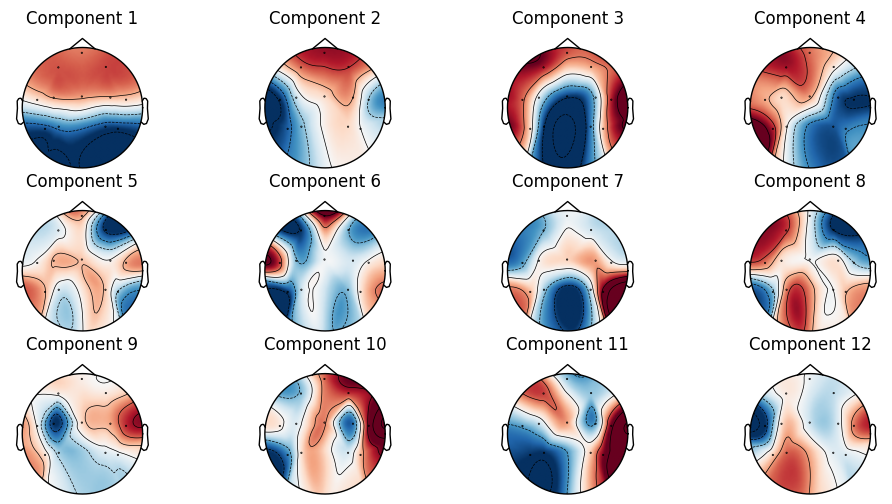

In [14]:
# perform ICA analysis
# convert raw data to ndarray of shape (n_subj, n_dim, n_times)
X = np.array([raws_filtered[subject_id].get_data() for subject_id in subject_ids])
print('Data shape for ICA:', X.shape)  # Should be (n_subj, n_dim, n_times  )
W, ISC, A = fit(X, k = 12)

print('ICA analysis completed.')
# plot all components' topographies
fig = plt.figure(figsize=(12, 6))
for i in range(W.shape[1]):
    ax = fig.add_subplot(3, 4, i+1)
    im, cn = mne.viz.plot_topomap(A[:, i], pos=raws_filtered[subject_ids[0]].info, axes=ax, show=False)
    ax.set_title('Component {}'.format(i+1))
plt.show()


(10, 12, 311752)


/tmp/ipykernel_280505/2214795223.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


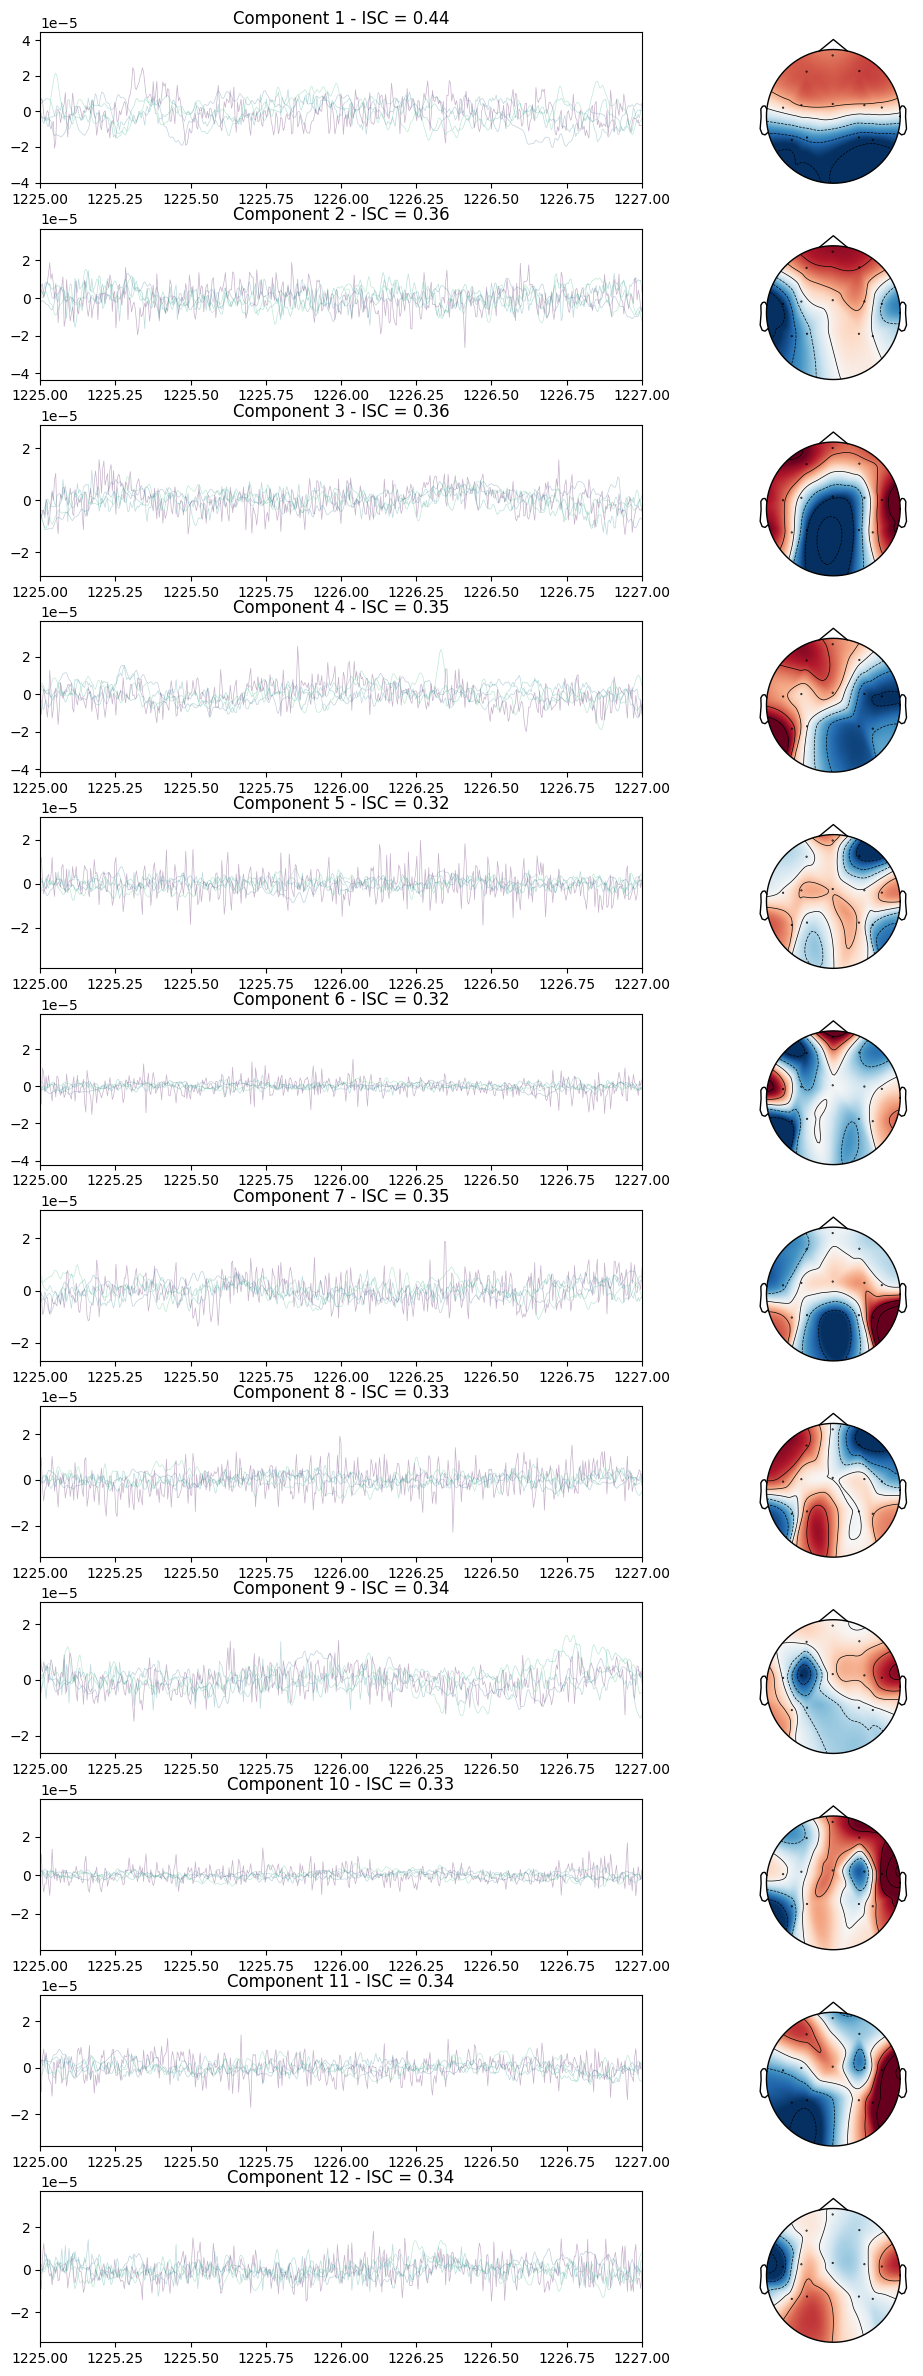

In [15]:
CCA = {
    'W': W,
    'ISC': ISC,
    'A': A,
    'times': raws_filtered[subject_ids[0]].times,
    'info': raws_filtered[subject_ids[0]].info,
    # epochs == subjects in this case
    'epochs': X,
}

fig = plot_CCA(CCA, plot_trials=True, plot_evk=False, plot_signal=False, collapse=False, xlim=(20*60 + 25,20*60 + 27),trials_alpha=0.3, width=12)
fig.show()


In [16]:
mne.epochs.equalize_epoch_counts(epochs_dict.values())
sampling_rate = epochs_dict[1].info['sfreq']
print(f'Equalized epoch counts across subjects. Sampling rate: {sampling_rate} Hz')

Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Equalized epoch counts across subjects. Sampling rate: 250.0 Hz


In [17]:
# Check the first few subjects' epochs to see if they have bad channels marked
for subject_id in [1, 2, 3]:
    print(f"\nSubject {subject_id}:")
    print(f"  Epochs bad channels: {epochs_dict[subject_id].info['bads']}")
    print(f"  Filtered raw bad channels: {raws_filtered[subject_id].info['bads']}")
    print(f"  Number of epochs: {len(epochs_dict[subject_id])}")
    print(f"  Number of channels: {len(epochs_dict[subject_id].ch_names)}")


Subject 1:
  Epochs bad channels: []
  Filtered raw bad channels: []
  Number of epochs: 11
  Number of channels: 32

Subject 2:
  Epochs bad channels: []
  Filtered raw bad channels: []
  Number of epochs: 11
  Number of channels: 32

Subject 3:
  Epochs bad channels: []
  Filtered raw bad channels: []
  Number of epochs: 11
  Number of channels: 32


In [18]:
# Check data statistics for each subject's epochs
for subject_id in subject_ids:
    data = epochs_dict[subject_id].get_data()
    print(f"\nSubject {subject_id}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Mean: {np.mean(data):.6e}")
    print(f"  Std: {np.std(data):.6e}")
    print(f"  Min: {np.min(data):.6e}")
    print(f"  Max: {np.max(data):.6e}")
    print(f"  Has NaN: {np.any(np.isnan(data))}")
    print(f"  Has Inf: {np.any(np.isinf(data))}")


Subject 1:
  Data shape: (11, 32, 1751)
  Mean: -1.438072e-08
  Std: 1.538346e-05
  Min: -3.105556e-04
  Max: 3.524999e-04
  Has NaN: False
  Has Inf: False

Subject 2:
  Data shape: (11, 32, 1751)
  Mean: nan
  Std: nan
  Min: nan
  Max: nan
  Has NaN: True
  Has Inf: False

Subject 3:
  Data shape: (11, 32, 1751)
  Mean: nan
  Std: nan
  Min: nan
  Max: nan
  Has NaN: True
  Has Inf: False

Subject 4:
  Data shape: (11, 32, 1751)
  Mean: -1.913531e-07
  Std: 1.547550e-05
  Min: -2.085065e-04
  Max: 2.497607e-04
  Has NaN: False
  Has Inf: False

Subject 5:
  Data shape: (11, 32, 1751)
  Mean: -3.047907e-08
  Std: 1.434661e-05
  Min: -2.476758e-04
  Max: 2.354531e-04
  Has NaN: False
  Has Inf: False

Subject 6:
  Data shape: (11, 32, 1751)
  Mean: 3.784834e-08
  Std: 1.847611e-05
  Min: -6.420055e-04
  Max: 5.437894e-04
  Has NaN: False
  Has Inf: False

Subject 7:
  Data shape: (11, 32, 1751)
  Mean: -8.844577e-09
  Std: 2.375168e-05
  Min: -1.265115e-03
  Max: 1.223811e-03
  Has N

/tmp/ipykernel_280505/3110971342.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_dict[subject_id].get_data()
/tmp/ipykernel_280505/3110971342.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_dict[subject_id].get_data()
/tmp/ipykernel_280505/3110971342.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_dict[subject_id].get_data()
/tmp/ipykernel_280505/3110971342.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_dict[subject_id].get_data()
/tmp/ipykernel_280505/3110971342.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7.

In [19]:
# Check if NaNs exist in the raw data before epoching
for subject_id in [2, 3, 8, 9, 10]:
    raw_data = raws_filtered_no_regres[subject_id].get_data()
    print(f"Subject {subject_id} - Raw (no regres) has NaN: {np.any(np.isnan(raw_data))}")
    
    # Check specific channels
    if np.any(np.isnan(raw_data)):
        nan_channels = [raws_filtered_no_regres[subject_id].ch_names[i] 
                       for i in range(len(raws_filtered_no_regres[subject_id].ch_names)) 
                       if np.any(np.isnan(raw_data[i, :]))]
        print(f"  Channels with NaN: {nan_channels}")

Subject 2 - Raw (no regres) has NaN: True
  Channels with NaN: ['ERB2']
Subject 3 - Raw (no regres) has NaN: True
Subject 3 - Raw (no regres) has NaN: True
  Channels with NaN: ['ERA1']
Subject 8 - Raw (no regres) has NaN: True
  Channels with NaN: ['ELA1', 'ELC1']
Subject 9 - Raw (no regres) has NaN: True
  Channels with NaN: ['ELT', 'ERK']
Subject 10 - Raw (no regres) has NaN: True
  Channels with NaN: ['ELA1']


In [20]:
# Check what channels are in the epochs
print("Epoch channels for Subject 2:")
print(epochs_dict[2].ch_names)
print(f"\nChannel types: {epochs_dict[2].get_channel_types()}")

# Check if ear-EEG channels are somehow in the epochs
ear_eeg_channels = ['ELA1', 'ELA2', 'ELB1', 'ELB2', 'ELC1', 'ELC2', 'ELK', 'ELT',
                    'ERA1', 'ERA2', 'ERB1', 'ERB2', 'ERC1', 'ERC2', 'ERK', 'ERT']
epochs_channels = set(epochs_dict[2].ch_names)
ear_in_epochs = [ch for ch in ear_eeg_channels if ch in epochs_channels]
print(f"\nEar-EEG channels in epochs: {ear_in_epochs}")

Epoch channels for Subject 2:
['ELA1', 'ELA2', 'ELB1', 'ELB2', 'ELC1', 'ELC2', 'ELK', 'ELT', 'ERA1', 'ERA2', 'ERB1', 'ERB2', 'ERC1', 'ERC2', 'ERK', 'ERT', 'C3', 'F3', 'P3', 'P7', 'T7', 'C4', 'F4', 'P4', 'P8', 'T8', 'AFz', 'Cz', 'HL_EOG', 'HR_EOG', 'VA_EOG', 'VB_EOG']

Channel types: ['misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'misc', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eog', 'eog', 'eog']

Ear-EEG channels in epochs: ['ELA1', 'ELA2', 'ELB1', 'ELB2', 'ELC1', 'ELC2', 'ELK', 'ELT', 'ERA1', 'ERA2', 'ERB1', 'ERB2', 'ERC1', 'ERC2', 'ERK', 'ERT']


In [21]:
# Solution: Pick only EEG and EOG channels before creating epochs
# Let's recreate the epochs without the ear-EEG channels

epochs_dict_fixed = {}

for subject_id in subject_ids:
    # Pick only EEG and EOG channels (exclude misc/ear-EEG)
    raw_for_epochs = raws_filtered_no_regres[subject_id].copy()
    raw_for_epochs.pick(picks=['eeg', 'eog'])
    
    epochs = create_epochs_from_movie_events(
        raw_for_epochs,
        event_names=byd_movie_events,
        tmin=-2.0,
        tmax=5.0,
    )
    epochs_dict_fixed[subject_id] = epochs
    print(f'Subject {subject_id}: {len(epochs)} epochs, {len(epochs.ch_names)} channels')

# Verify no NaN values
print("\n=== Verifying no NaN values ===")
for subject_id in subject_ids:
    data = epochs_dict_fixed[subject_id].get_data(copy=True)
    has_nan = np.any(np.isnan(data))
    print(f"Subject {subject_id}: Has NaN = {has_nan}")

Used Annotations descriptions: [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('even_more_loading'), np.str_('gun_fire'), np.str_('gun_girl'), np.str_('gun_loading'), np.str_('gun_maid'), np.str_('gun_mother'), np.str_('gun_mother_father'), np.str_('gun_postman'), np.str_('gun_shopkeeper'), np.str_('more_loading'), np.str_('next_bullet')]
Not setting metadata
11 matching events found
No baseline correction applied
Not setting metadata
11 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 11 events and 1751 original time points ...
0 bad epochs dropped
Subject 1: 11 epochs, 16 channels
Used Annotations descriptions: [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('even_more_loading'), np.str_('gun_fire')

In [22]:
# Equalize epoch counts
mne.epochs.equalize_epoch_counts(list(epochs_dict_fixed.values()))
print("Equalized epoch counts")

# Now try ICA_fit with the fixed epochs
print("\nRunning ICA_fit with fixed epochs...")
icas_fixed = prep.ICA_fit(
    list(epochs_dict_fixed.values()),
    n_components=8,
    method='infomax',
    fit_params=dict(extended=True),
    random_state=97
)

print(f"\nSuccess! ICA fitted for {len(icas_fixed)} subjects")

Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Equalized epoch counts

Running ICA_fit with fixed epochs...
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(0.0004837055900368869)}
0 bad epochs dropped
Fitting ICA to data using 12 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 8 components
Computing Extended Infomax ICA
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 2.3s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(8.115171025862124e-05)}
    Rejecting  epoch

In [23]:
# Apply autoreject
icas_fixed_ac = ICA_autocorrect(icas_fixed, epochs_dict_fixed.values(), verbose=False)
cleaned_epochs_ICA_fixed, dic_epochs = prep.AR_local(
    icas_fixed_ac,
    strategy='union',
    threshold=50.0,
    verbose=False
)


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 12 PCA components


/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
/tmp/ipykernel_280505/4192951307.py:28: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")


Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 12 PCA components
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/12 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/12 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/11 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1 epoch: 10


  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


In [24]:


# Compute PSD for participant 1 in the Alpha-Low band
psd1 = analyses.pow(
    cleaned_epochs_ICA_fixed[0],
    fmin=7.5,
    fmax=11,
    n_fft=1000,
    n_per_seg=1000,
    epochs_average=True
)

# Compute PSD for participant 2 in the Alpha-Low band
psd2 = analyses.pow(
    cleaned_epochs_ICA_fixed[1],
    fmin=7.5,
    fmax=11,
    n_fft=1000,
    n_per_seg=1000,
    epochs_average=True
)

# Combine PSD data into a single array
data_psd = np.array([psd1.psd, psd2.psd])


Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


In [25]:


# Prepare data for connectivity analysis (combine both participants)
data_inter = np.array([cleaned_epochs_ICA_fixed[0], cleaned_epochs_ICA_fixed[1]])
result_intra = []

# Compute the analytic signal in each frequency band
complex_signal = analyses.compute_freq_bands(
    data_inter,
    sampling_rate,
    freq_bands,
    filter_length=int(sampling_rate),  # Adjust filter length based on sampling rate
    l_trans_bandwidth=5.0,  # Reduced transition bandwidth
    h_trans_bandwidth=5.0
)

# Compute connectivity using cross-correlation ('ccorr') and average across epochs
result = analyses.compute_sync(complex_signal, mode='ccorr', epochs_average=True)

# Determine the number of channels
n_ch = len(epochs_dict_fixed[1].info['ch_names'])

# Slice the connectivity matrix to get inter-brain connectivity in the Alpha-Low band
alpha_low, alpha_high = result[:, 0:n_ch, n_ch:2*n_ch]

# For further analysis, choose the Alpha-Low band values
values = alpha_low

# Compute a Z-score normalized connectivity matrix
C = (values - np.mean(values[:])) / np.std(values[:])

# Process intra-brain connectivity for each participant
for i in [0, 1]:
    # Slice intra-brain connectivity matrix
    alpha_low, alpha_high = result[:, (i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
    values_intra = alpha_low
    
    # Remove self-connections
    values_intra -= np.diag(np.diag(values_intra))
    
    # Compute Z-score normalization for intra connectivity
    C_intra = (values_intra - np.mean(values_intra[:])) / np.std(values_intra[:])
    result_intra.append(C_intra)

print('Connectivity analysis completed.')


Connectivity analysis completed.


In [29]:
print(epochs_dict_fixed[1].info['ch_names'])
print(epochs_dict_fixed[2].info['ch_names'])

['C3', 'F3', 'P3', 'P7', 'T7', 'C4', 'F4', 'P4', 'P8', 'T8', 'AFz', 'Cz', 'HL_EOG', 'HR_EOG', 'VA_EOG', 'VB_EOG']
['C3', 'F3', 'P3', 'P7', 'T7', 'C4', 'F4', 'P4', 'P8', 'T8', 'AFz', 'Cz', 'HL_EOG', 'HR_EOG', 'VA_EOG', 'VB_EOG']


In [35]:


# Compute mean PSD values for each channel across epochs for both participants
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)

# Combine the means into a single array for the t-test
X = np.array([psd1_mean, psd2_mean])

# Perform permutation t-test (using MNE) without correction for multiple comparisons
T_obs, p_values, H0 = mne.stats.permutation_t_test(
    X=X,
    n_permutations=5000,
    tail=0,
    n_jobs=1
)
print('Permutation t-test completed.')

# Alternatively, compute statistical conditions using HyPyP's statsCond function
statsCondTuple = hyp_stats.statsCond(
    data=data_psd,
    epochs=cleaned_epochs_ICA_fixed[0],
    n_permutations=5000,
    alpha=0.05
)

print(statsCondTuple)

print('Statistical condition tuple computed.')


Permuting 1 times (exact test)...
Permutation t-test completed.
Permuting 1 times (exact test)...
statsCond(T_obs=array([ 9.92276487,  1.73766794,  4.11213046, 18.7683801 ,  1.14534478,
        3.17053401,  1.74270702,  3.58048383,  4.31743452, 16.0517726 ,
        1.38584114, 10.03071043]), p_values=array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), H0=array([ 0.87309954, 18.7683801 ]), adj_p=(array([False, False, False, False, False, False, False, False, False,
       False, False, False]), array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])), T_obs_plot=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
Statistical condition tuple computed.
Permutation t-test completed.
Permuting 1 times (exact test)...
statsCond(T_obs=array([ 9.92276487,  1.73766794,  4.11213046, 18.7683801 ,  1.14534478,
        3.17053401,  1.74270702,  3.58048383,  4.31743452, 16.0517726 ,
        1.38584114, 10.03071043]), p_values=array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

In [34]:
noise_level = 1e-6  # Small noise to break exact duplicates
print(result_intra[0].shape)
print(result_intra[1].shape)

print(cleaned_epochs_ICA_fixed[0])

# Create connectivity matrix for a priori sensor connectivity using participant 1's sensor layout
con_matrixTuple = hyp_stats.con_matrix(cleaned_epochs_ICA_fixed[0], freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq
data_group = [
    np.array([psd1.psd + np.random.normal(0, noise_level, psd1.psd.shape) for _ in range(3)]),
    np.array([psd2.psd + np.random.normal(0, noise_level, psd2.psd.shape) for _ in range(3)])
]

# Perform non-parametric cluster-based permutation test on the fake groups
statscondCluster = hyp_stats.statscondCluster(
    data=data_group,
    freqs_mean=psd1.freq_list,
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Cluster-based permutation test for PSD completed.')




# Create connectivity matrix for intra-brain connectivity
con_matrixTuple = hyp_stats.con_matrix(
    epochs=cleaned_epochs_ICA_fixed[0],
    freqs_mean=np.arange(7.5, 11),
    draw=False
)

ch_con = con_matrixTuple.ch_con

# Create fake groups for intra-brain connectivity analysis
Alpha_Low = [
    np.array([
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape),
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape)
    ]),
    np.array([
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape),
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape)
    ])
]

print(Alpha_Low[0].shape)
print(Alpha_Low[1].shape)
# Run cluster-based permutation test for intra-brain connectivity
statscondCluster_intra = hyp_stats.statscondCluster(
    data=Alpha_Low,
    freqs_mean=np.arange(7.5, 11),
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Inter-brain connectivity cluster test completed.')
print('Intra-brain connectivity cluster test completed.')

(16, 16)
(8, 8)
<Epochs |  10 events (all good), -2 – 5 s, baseline off, ~1.6 MB, data loaded,
 np.str_('even_more_loading'): 1
 np.str_('gun_fire'): 0
 np.str_('gun_girl'): 1
 np.str_('gun_loading'): 1
 np.str_('gun_maid'): 1
 np.str_('gun_mother'): 1
 np.str_('gun_mother_father'): 1
 np.str_('gun_postman'): 1
 np.str_('gun_shopkeeper'): 1
 np.str_('more_loading'): 1
 and 1 more events ...>
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 12
Using a threshold of 7.708647
stat_fun(H1): min=6.869648307584477e-07 max=39.04283921080221
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Cluster-based permutation test for PSD completed.
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 12
(2, 16, 16)
(2, 8, 8)
Using a threshold of 18.512821


ValueError: All samples mush have the same size

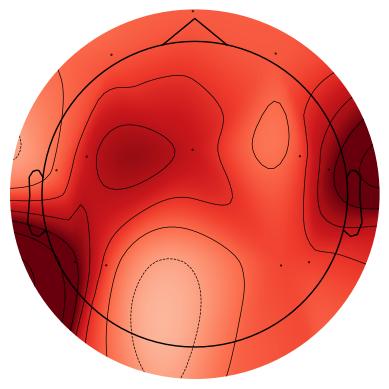

Sensor-level T-values plotted.


In [36]:


# Plot sensor-level T-values using the t-statistics computed earlier
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs,
    epochs=cleaned_epochs_ICA_fixed[0],
)
print('Sensor-level T-values plotted.')



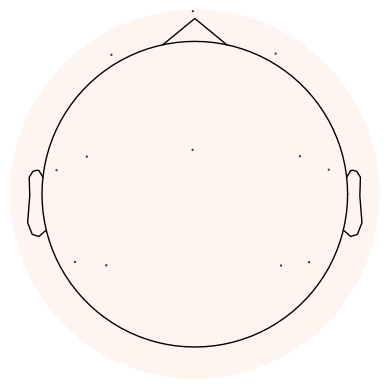

Significant sensors T-values plotted.


In [37]:


# Plot only the T-values for sensors that are statistically significant
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot,
    epochs=cleaned_epochs_ICA_fixed[0]
)
print('Significant sensors T-values plotted.')

    

IndexError: index 8 is out of bounds for axis 1 with size 8

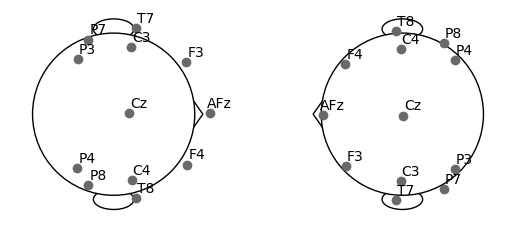

In [ ]:
viz.viz_2D_topomap_inter(cleaned_epochs_ICA_fixed[0], cleaned_epochs_ICA_fixed[1], C, threshold='auto', steps=10, lab=True)

IndexError: index 8 is out of bounds for axis 1 with size 8

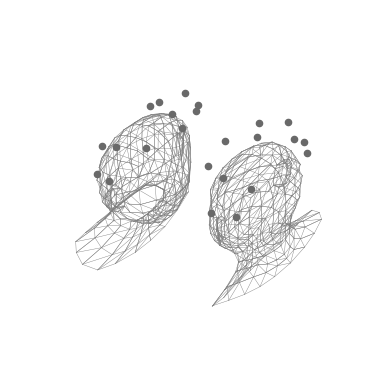

In [39]:


viz.viz_3D_inter(epochs_dict_fixed[1], epochs_dict_fixed[2], C, threshold='auto', steps=10, lab=False)
print('3D inter-brain connectivity visualization completed.')



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

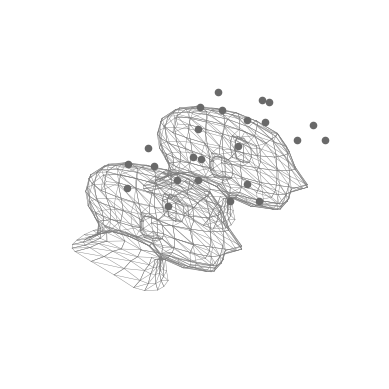

In [42]:


viz.viz_3D_intra(epochs_dict_fixed[1], epochs_dict_fixed[2],
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False,
                )

print('3D intra-brain connectivity visualization completed.')

